## CAN ACTIVE LEARNING PREEMPTIVELY MITIGATE FAIRNESS ISSUES?
The purpose of this notebook is to demonstrate the prilimary results of our recent [contribution](https://arxiv.org/abs/2104.06879#:~:text=We%20found%20that%2C%20while%20addressing,benchmarks%20and%20metrics%20we%20explored.) to ICLR workshop of Responsible AI 2021.
We show that active learning could help in creating fairer datasets without the need to know the bias in the dataset. This is important since in real scenarios, the bias could be very well hidden and unless proper analysis done, this bias is unrecognized and hence impossible to remove. Using active learning (i.e. BALD), we show that the prior knowledge of the bias is not necessary and hence it could be easier to integrate this setup in pipelines to make sure that the dataset is generally fairer and the possible biases are reduced. 

For the purpose of this demo, we use [synbols](https://github.com/ElementAI/synbols) dataset. Synbols is the new state of the art for fast generating of synthetic datasets.
In order to have requirements of this notebook installed, you would need to run the notebook in using the dockerfile located in "baal/docs/notebooks/notebook_support/Docker_biased_data".


### Introducing bias in dataset
We introduce bias in dataset using color. For this purpose, we create a set of `a` and `d` letters with different fonts and shapes, however majority of `a` letters is red and majority of `d` letters is blue. We would like to see if active learning help in removing/reducing this bias.


In [1]:
import numpy as np
from math import pi
from synbols.data_io import pack_dataset
from synbols import drawing
from synbols import generate

class InfoSolid(drawing.SolidColor):
    def attribute_dict(self):
        d = super().attribute_dict()
        d['color'] = self.color
        return d
    
rng = np.random.RandomState(1337)
p = .1
blue = (0,0,255)
red = (255, 0, 0)

class SpuriousSampler:
    def __init__(self, p):
        self.p = p
        
    def __call__(self, seed):
        """Makes brightness dependent on scale and color dependant on symbol."""
        rng = np.random.RandomState(seed)
        color = [blue, red][rng.choice([0, 1], p=[self.p, 1-self.p])]
        char = rng.choice(['a', 'd'])
        color_p = {'a':self.p, 'd':1-self.p}[char]
        color = [blue, red][rng.choice([0, 1], p=[color_p, 1-color_p])]

        fg = InfoSolid(color)
        fg.color = color

        attr_sampler = generate.basic_attribute_sampler(
            char=char, foreground=fg, background=None, inverse_color=False, resolution=(64, 64))
        d = attr_sampler()
        return d


def make_dataset(p, seed, num):
    attribute_sampler = SpuriousSampler(p=p)
    x, mask, y = pack_dataset(generate.dataset_generator(attribute_sampler, num, generate.flatten_mask, dataset_seed=seed))
    for yi in y:
        yi['color'] = 'red' if yi['foreground']['color'] == red else 'blue'
    return (x,y,y)             

train_set = make_dataset(p=0.9, seed=1000, num=10000)
test_set = make_dataset(p=0.5, seed=2000, num=5000)
dataset = {'train': train_set, 'test': test_set}

100%|██████████| 5000/5000 [01:16<00:00, 65.06it/s]


### Prepare model and dataset to be used in BaaL setup
As usual we wrap the train_set in `ActiveLearningDataset` and using vgg16 as default model, we use the BaaL's `patch_module` to create a dropout layer which performs in inference time.

In [2]:
import numpy as np
from torch.utils.data import Dataset


class SynbolDataset(Dataset):
    def __init__(self, x, y, metadata, target_key, attribute, transform, encode_groups=False):
        self.x, self.transform = x, transform
        self.target_key = target_key
        self.attribute = attribute
        self._all_target = sorted(np.unique([d[self.target_key] for d in metadata]).tolist())
        self.encode_groups = encode_groups
        self._all_attribute = sorted(np.unique([d[self.attribute] for d in metadata]).tolist())

        self.metadata = metadata

    def get_attr(self, item, attr, index=None):
        out = self.metadata[item][attr]
        if index:
            out = index.index(out)
        return out

    def __len__(self):
        return len(self.x)

    def __getitem__(self, item):
        target = self.get_attr(item, self.target_key, self._all_target)
        attr = self.get_attr(item, self.attribute,
                             index=self._all_attribute if self.encode_groups else None)
        return self.transform(self.x[item]), {'target': target, self.attribute: attr}

In [3]:
from torchvision.transforms import transforms

IMG_SIZE=64

def get_datasets(dataset, initial_pool, attribute, target_key):
    """
    Get the dataset for the experiment.
    Args:
        dataset: The synbol generated dataset.
        initial_pool:
        attribute:
        target_key:
    Returns:
    """
    transform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize((IMG_SIZE, IMG_SIZE)),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(30),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    test_transform = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                              (0.2023, 0.1994, 0.2010))])
    train_ds = dataset['train']
    test_ds = dataset['test']
    ds = SynbolDataset(*train_ds, target_key=target_key, attribute=attribute,
                           transform=transform)

    test_set = SynbolDataset(*test_ds, target_key=target_key, attribute=attribute,
                                 transform=test_transform)

    active_set = ActiveLearningDataset(ds, pool_specifics={'transform': test_transform})
    active_set.label_randomly(initial_pool)
    return active_set, test_set

In [4]:
from torchvision import models
from torch.hub import load_state_dict_from_url
from baal.bayesian.dropout import patch_module

#set use_cuda to False if you don't have access to GPUS
use_cuda=True

model = models.vgg16(pretrained=False, num_classes=2)
weights = load_state_dict_from_url('https://download.pytorch.org/models/vgg16-397923af.pth')
weights = {k: v for k, v in weights.items() if 'classifier.6' not in k}
model.load_state_dict(weights, strict=False)

# change dropout layer to MCDropout
model = patch_module(model)

if use_cuda:
    model.cuda()


We wrap the pytorch criterion to accomodate target being a dictionary.

In [5]:
from torch import nn

class MyCrit(nn.Module):
    def __init__(self, crit):
        super().__init__()
        self.crit = crit

    def forward(self, input, target):
        return self.crit(input, target['target'])

We define `AggregationCount` as a `baal.Metrics` module, so that we can have a report of number of samples per attribute added to each character.

In [6]:
import numpy as np
import torch
from baal.utils.metrics import Metrics


def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    else:
        return np.array(list(x))


class AggregateCounts(Metrics):
    def __init__(self, attribute, **kwargs):
        """
        Wrapper arround fairlearn metrics for a per-class, per-group.
        Args:
            attribute (str): attribute to get from the target
            **kwargs: kwargs for the metrics. (`average` for example)
        """
        self.attribute = attribute
        self.kwargs = kwargs
        super().__init__(**kwargs)

    def reset(self):
        self._ypred = []
        self._ypred_probs = []
        self._ytrue = []
        self._sensitive_attr = []

    def update(self, output=None, target=None):
        if isinstance(output, (tuple, list)):
            # If the model predicts multiple things, the cls is the first.
            output = output[0]
        clss, clrs = target['target'], target[self.attribute]
        self._ypred.append(np.argmax(output.detach().cpu().numpy(), 1))
        self._ypred_probs.append(output.detach().cpu().numpy())
        self._ytrue.append(clss.detach().cpu().numpy())
        self._sensitive_attr.append(to_numpy(clrs))

    @property
    def value(self):
        sensitive, y_pred, _, y_true = self.aggregate_data()
        mets = {}
        # Count
        for ch in np.unique(y_true):
            mask = y_true == ch
            colors = np.array(sensitive)[mask].copy()
            counts = np.unique(colors, return_counts=True)
            for k, c in zip(*counts):
                mets[f"count_{ch}_{k}"] = int(c)
        return mets

    def aggregate_data(self):
        y_true = np.concatenate(self._ytrue, 0).reshape([-1])
        y_pred = np.concatenate(self._ypred, 0).reshape([-1])
        y_pred_probs = np.concatenate(self._ypred_probs, 0).reshape([y_pred.shape[0], -1])
        sensitive = np.concatenate(self._sensitive_attr, 0).reshape([-1])
        return sensitive, y_pred, y_pred_probs, y_true

Let's now train the model with active learning. As usual, we compare `bald` with `random` but this time, we are looking for something else in the results!

In [7]:
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import torch
from torch import optim
from torch.nn import CrossEntropyLoss
from baal.modelwrapper import ModelWrapper
from baal.active.heuristics import BALD
from baal.active import get_heuristic, ActiveLearningDataset
from baal.active.active_loop import ActiveLearningLoop

heuristics = ['bald', 'random']

logs = {'bald': {}, 'random': {}}

for heuristic_name in heuristics:
    active_set, test_set = get_datasets(dataset, initial_pool=500, attribute='color', target_key='char')

    heuristic = get_heuristic(name=heuristic_name, shuffle_prop=0.0)

    criterion = MyCrit(CrossEntropyLoss())

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

    wrapped_model = ModelWrapper(model, criterion)

    wrapped_model.add_metric('aggregate_res', lambda: AggregateCounts(attribute='color'))

    # save imagenet weights
    init_weights = deepcopy(model.state_dict())


    bald = BALD()



    # for prediction we use a smaller batchsize
    # since it is slower
    active_loop = ActiveLearningLoop(active_set,
                                     wrapped_model.predict_on_dataset,
                                     heuristic,
                                     50,
                                     batch_size=16,
                                     iterations=20,
                                     use_cuda=use_cuda,
                                     workers=0)
    learning_epoch = 20
    for epoch in tqdm(range(100000)):
        wrapped_model.load_state_dict(init_weights)
        wrapped_model.train_on_dataset(active_set, optimizer, batch_size=32,
                                       epoch=learning_epoch, use_cuda=True, workers=12)

        # Validation!
        wrapped_model.test_on_dataset(test_set, batch_size=32, use_cuda=use_cuda,
                                      workers=12, average_predictions=20)

        should_continue = active_loop.step()
        if not should_continue:
            break

        # Send logs
        fair_train = wrapped_model.metrics[f'train_aggregate_res'].value
        epoch_logs = {
            'epoch': epoch,
            'test_loss': wrapped_model.metrics['test_loss'].value,
            'active_train_size': len(active_set)}

        agg_res = {'train_' + k: v for k, v in fair_train.items()}
        epoch_logs.update(agg_res)

        for k, v in epoch_logs.items():
            if k in logs[heuristic_name].keys():
                logs[heuristic_name][k].append(v)
            else:
                logs[heuristic_name][k] = [v]

        if len(active_set) > 2000:
            break


  0%|          | 0/100000 [00:00<?, ?it/s]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T13:21:54.172700Z [info     ] Starting training              dataset=500 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T13:23:19.100227Z [info     ] Training complete              train_loss=0.04907096177339554
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T13:23:19.103329Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T13:24:03.611456Z [info     ] Evaluation complete            test_loss=0.8013197183609009
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T13:24:03.618353Z [info     ] Start Predict                  dataset=9500

 24%|██▎       | 140/594 [00:21<01:07,  6.69it/s]


 49%|████▉     | 294/594 [00:43<00:45,  6.62it/s]


 75%|███████▌  | 448/594 [01:06<00:21,  6.68it/s]


100%|██████████| 594/594 [01:28<00:00,  6.69it/s]

  0%|          | 1/100000 [03:38<6064:34:46, 218.33s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T13:25:32.500692Z [info     ] Starting training              dataset=550 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T13:27:01.100863Z [info     ] Training complete              train_loss=0.06001168489456177
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T13:27:01.103321Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T13:27:45.524252Z [info     ] Evaluation complete            test_loss=0.6948421001434326
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T13:27:45.584896Z [info     ] Start Predict                  dataset=9450

 24%|██▎       | 140/591 [00:20<01:08,  6.63it/s]


 50%|████▉     | 294/591 [00:43<00:44,  6.69it/s]


 76%|███████▌  | 448/591 [01:06<00:21,  6.70it/s]


100%|██████████| 591/591 [01:28<00:00,  6.71it/s]

  0%|          | 2/100000 [07:19<6088:48:24, 219.20s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T13:29:13.741460Z [info     ] Starting training              dataset=600 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T13:30:46.106797Z [info     ] Training complete              train_loss=0.030749326571822166
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T13:30:46.109976Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T13:31:30.404166Z [info     ] Evaluation complete            test_loss=0.5662632584571838
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T13:31:30.410829Z [info     ] Start Predict                  dataset=9400

 24%|██▍       | 140/588 [00:21<01:07,  6.67it/s]


 50%|█████     | 294/588 [00:43<00:43,  6.75it/s]


 76%|███████▌  | 448/588 [01:06<00:20,  6.83it/s]


100%|██████████| 588/588 [01:27<00:00,  6.70it/s]

  0%|          | 3/100000 [11:04<6132:37:37, 220.78s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T13:32:58.209662Z [info     ] Starting training              dataset=650 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T13:34:32.709431Z [info     ] Training complete              train_loss=0.05471733585000038
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T13:34:32.712622Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T13:35:17.043867Z [info     ] Evaluation complete            test_loss=0.5037316083908081
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T13:35:17.084436Z [info     ] Start Predict                  dataset=9350

 24%|██▍       | 140/585 [00:20<01:06,  6.66it/s]


 50%|█████     | 294/585 [00:43<00:42,  6.78it/s]


 77%|███████▋  | 448/585 [01:06<00:20,  6.65it/s]


100%|██████████| 585/585 [01:27<00:00,  6.70it/s]

  0%|          | 4/100000 [14:50<6177:55:42, 222.41s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T13:36:44.434621Z [info     ] Starting training              dataset=700 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T13:38:23.419804Z [info     ] Training complete              train_loss=0.0871162936091423
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T13:38:23.423120Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T13:39:07.895330Z [info     ] Evaluation complete            test_loss=0.38115036487579346
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T13:39:07.902326Z [info     ] Start Predict                  dataset=9300

 24%|██▍       | 140/582 [00:20<01:05,  6.71it/s]


 51%|█████     | 294/582 [00:43<00:43,  6.61it/s]


 77%|███████▋  | 448/582 [01:06<00:20,  6.63it/s]


100%|██████████| 582/582 [01:26<00:00,  6.71it/s]


  0%|          | 5/100000 [18:40<6243:00:37, 224.76s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T13:40:34.666951Z [info     ] Starting training              dataset=750 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T13:42:17.397654Z [info     ] Training complete              train_loss=0.10327329486608505
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T13:42:17.400545Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T13:43:01.808858Z [info     ] Evaluation complete            test_loss=0.4251984655857086
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T13:43:01.815780Z [info     ] Start Predict                  dataset=9250

 24%|██▍       | 140/579 [00:20<01:04,  6.81it/s]


 51%|█████     | 294/579 [00:44<00:42,  6.63it/s]


 77%|███████▋  | 448/579 [01:07<00:19,  6.73it/s]


100%|██████████| 579/579 [01:26<00:00,  6.69it/s]


  0%|          | 6/100000 [22:34<6317:47:08, 227.45s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T13:44:28.407404Z [info     ] Starting training              dataset=800 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T13:46:13.525892Z [info     ] Training complete              train_loss=0.08019774407148361
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T13:46:13.529749Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T13:46:57.914112Z [info     ] Evaluation complete            test_loss=0.5976271629333496
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T13:46:57.920662Z [info     ] Start Predict                  dataset=9200

 24%|██▍       | 140/575 [00:20<01:05,  6.67it/s]


 51%|█████     | 294/575 [00:43<00:42,  6.56it/s]


 78%|███████▊  | 448/575 [01:06<00:19,  6.68it/s]


100%|██████████| 575/575 [01:25<00:00,  6.69it/s]


  0%|          | 7/100000 [26:29<6384:36:30, 229.86s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T13:48:23.888955Z [info     ] Starting training              dataset=850 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T13:50:12.812028Z [info     ] Training complete              train_loss=0.0756210908293724
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T13:50:12.883245Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T13:50:57.104539Z [info     ] Evaluation complete            test_loss=0.37024733424186707
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T13:50:57.111737Z [info     ] Start Predict                  dataset=9150

 24%|██▍       | 140/572 [00:21<01:04,  6.65it/s]


 51%|█████▏    | 294/572 [00:44<00:41,  6.66it/s]


 78%|███████▊  | 448/572 [01:07<00:18,  6.72it/s]


100%|██████████| 572/572 [01:25<00:00,  6.68it/s]

  0%|          | 8/100000 [30:28<6459:38:39, 232.57s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T13:52:22.762779Z [info     ] Starting training              dataset=900 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T13:54:13.514208Z [info     ] Training complete              train_loss=0.12440874427556992
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T13:54:13.584000Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T13:54:57.809296Z [info     ] Evaluation complete            test_loss=0.29917994141578674
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T13:54:57.815843Z [info     ] Start Predict                  dataset=9100

 25%|██▍       | 140/569 [00:20<01:04,  6.69it/s]


 52%|█████▏    | 294/569 [00:43<00:41,  6.62it/s]


 79%|███████▊  | 448/569 [01:07<00:18,  6.61it/s]


100%|██████████| 569/569 [01:24<00:00,  6.70it/s]

  0%|          | 9/100000 [34:28<6521:46:11, 234.80s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T13:56:22.792445Z [info     ] Starting training              dataset=950 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T13:58:15.527293Z [info     ] Training complete              train_loss=0.09123747050762177
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T13:58:15.529881Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T13:58:59.917027Z [info     ] Evaluation complete            test_loss=0.2541620433330536
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T13:58:59.925265Z [info     ] Start Predict                  dataset=9050

 25%|██▍       | 140/566 [00:20<01:02,  6.86it/s]


 52%|█████▏    | 294/566 [00:43<00:41,  6.54it/s]


 79%|███████▉  | 448/566 [01:06<00:17,  6.87it/s]


100%|██████████| 566/566 [01:24<00:00,  6.72it/s]

  0%|          | 10/100000 [38:29<6576:12:42, 236.77s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:00:24.138545Z [info     ] Starting training              dataset=1000 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:02:20.209429Z [info     ] Training complete              train_loss=0.10859714448451996
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:02:20.212183Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:03:04.407985Z [info     ] Evaluation complete            test_loss=0.3142414093017578
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:03:04.415137Z [info     ] Start Predict                  dataset=9000

 25%|██▍       | 140/563 [00:20<01:03,  6.68it/s]


 52%|█████▏    | 294/563 [00:43<00:39,  6.77it/s]


 80%|███████▉  | 448/563 [01:06<00:17,  6.68it/s]


100%|██████████| 563/563 [01:23<00:00,  6.72it/s]

  0%|          | 11/100000 [42:34<6637:40:12, 238.98s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:04:28.291082Z [info     ] Starting training              dataset=1050 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:06:25.312282Z [info     ] Training complete              train_loss=0.08423984050750732
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:06:25.315165Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:07:09.425532Z [info     ] Evaluation complete            test_loss=0.38589343428611755
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:07:09.490204Z [info     ] Start Predict                  dataset=8950

 25%|██▌       | 140/560 [00:20<01:01,  6.88it/s]


 52%|█████▎    | 294/560 [00:44<00:39,  6.67it/s]


 80%|████████  | 448/560 [01:07<00:16,  6.80it/s]


100%|██████████| 560/560 [01:23<00:00,  6.69it/s]

  0%|          | 12/100000 [46:39<6687:07:46, 240.77s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:08:33.216501Z [info     ] Starting training              dataset=1100 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:10:33.706525Z [info     ] Training complete              train_loss=0.09978768229484558
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:10:33.709213Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:11:18.108018Z [info     ] Evaluation complete            test_loss=0.2657582759857178
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:11:18.114943Z [info     ] Start Predict                  dataset=8900

 25%|██▌       | 140/557 [00:21<01:02,  6.69it/s]


 53%|█████▎    | 294/557 [00:44<00:39,  6.69it/s]


 80%|████████  | 448/557 [01:07<00:16,  6.66it/s]


100%|██████████| 557/557 [01:23<00:00,  6.68it/s]


  0%|          | 13/100000 [50:47<6750:12:41, 243.04s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:12:41.561094Z [info     ] Starting training              dataset=1150 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:14:42.000186Z [info     ] Training complete              train_loss=0.11231104284524918
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:14:42.003099Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:15:26.521093Z [info     ] Evaluation complete            test_loss=0.21630586683750153
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:15:26.526948Z [info     ] Start Predict                  dataset=8850

 25%|██▌       | 140/554 [00:20<01:01,  6.74it/s]


 53%|█████▎    | 294/554 [00:43<00:38,  6.68it/s]


 81%|████████  | 448/554 [01:06<00:15,  6.71it/s]


100%|██████████| 554/554 [01:22<00:00,  6.70it/s]


  0%|          | 14/100000 [54:55<6789:28:48, 244.46s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:16:49.320115Z [info     ] Starting training              dataset=1200 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:18:52.735122Z [info     ] Training complete              train_loss=0.09681836515665054
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:18:52.782641Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:19:37.096878Z [info     ] Evaluation complete            test_loss=0.2956753075122833
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:19:37.103343Z [info     ] Start Predict                  dataset=8800

 25%|██▌       | 140/550 [00:20<01:01,  6.70it/s]


 53%|█████▎    | 294/550 [00:43<00:38,  6.63it/s]


 81%|████████▏ | 448/550 [01:07<00:15,  6.70it/s]


100%|██████████| 550/550 [01:22<00:00,  6.68it/s]


  0%|          | 15/100000 [59:05<6836:39:51, 246.16s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:20:59.447555Z [info     ] Starting training              dataset=1250 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:23:06.201771Z [info     ] Training complete              train_loss=0.20877452194690704
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:23:06.203976Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:23:50.613884Z [info     ] Evaluation complete            test_loss=0.18791767954826355
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:23:50.620720Z [info     ] Start Predict                  dataset=8750

 26%|██▌       | 140/547 [00:20<01:01,  6.58it/s]


 54%|█████▎    | 294/547 [00:44<00:38,  6.53it/s]


 82%|████████▏ | 448/547 [01:07<00:14,  6.67it/s]


100%|██████████| 547/547 [01:21<00:00,  6.68it/s]

  0%|          | 16/100000 [1:03:18<6895:23:39, 248.27s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:25:12.660736Z [info     ] Starting training              dataset=1300 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:27:20.925023Z [info     ] Training complete              train_loss=0.1674506515264511
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:27:20.928310Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:28:05.104840Z [info     ] Evaluation complete            test_loss=0.22110679745674133
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:28:05.112948Z [info     ] Start Predict                  dataset=8700

 26%|██▌       | 140/544 [00:20<00:59,  6.75it/s]


 54%|█████▍    | 294/544 [00:44<00:37,  6.74it/s]


 82%|████████▏ | 448/544 [01:07<00:14,  6.71it/s]


100%|██████████| 544/544 [01:21<00:00,  6.69it/s]

  0%|          | 17/100000 [1:07:32<6942:01:29, 249.96s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:29:26.540587Z [info     ] Starting training              dataset=1350 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:31:39.786014Z [info     ] Training complete              train_loss=0.10824580490589142
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:31:39.789480Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:32:24.185328Z [info     ] Evaluation complete            test_loss=0.1632518470287323
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:32:24.195238Z [info     ] Start Predict                  dataset=8650

 26%|██▌       | 140/541 [00:20<00:59,  6.79it/s]


 54%|█████▍    | 294/541 [00:43<00:36,  6.69it/s]


 83%|████████▎ | 448/541 [01:07<00:13,  6.73it/s]


100%|██████████| 541/541 [01:20<00:00,  6.69it/s]

  0%|          | 18/100000 [1:11:50<7014:06:33, 252.55s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:33:45.155353Z [info     ] Starting training              dataset=1400 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:35:58.108890Z [info     ] Training complete              train_loss=0.12975840270519257
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:35:58.183217Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:36:42.606894Z [info     ] Evaluation complete            test_loss=0.28366342186927795
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:36:42.614776Z [info     ] Start Predict                  dataset=8600

 26%|██▌       | 140/538 [00:21<00:59,  6.65it/s]


 55%|█████▍    | 294/538 [00:44<00:36,  6.73it/s]


 83%|████████▎ | 448/538 [01:07<00:13,  6.69it/s]


100%|██████████| 538/538 [01:20<00:00,  6.67it/s]

  0%|          | 19/100000 [1:16:09<7060:37:38, 254.23s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:38:03.299885Z [info     ] Starting training              dataset=1450 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:40:22.612611Z [info     ] Training complete              train_loss=0.14449124038219452
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:40:22.615804Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:41:07.090093Z [info     ] Evaluation complete            test_loss=0.1980649083852768
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:41:07.097626Z [info     ] Start Predict                  dataset=8550

 26%|██▌       | 140/535 [00:21<00:59,  6.66it/s]


 55%|█████▍    | 294/535 [00:44<00:35,  6.70it/s]


 84%|████████▎ | 448/535 [01:07<00:12,  6.71it/s]


100%|██████████| 535/535 [01:20<00:00,  6.67it/s]

  0%|          | 20/100000 [1:20:33<7142:26:00, 257.18s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:42:27.357998Z [info     ] Starting training              dataset=1500 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:44:46.585878Z [info     ] Training complete              train_loss=0.10246240347623825
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:44:46.588659Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:45:31.216651Z [info     ] Evaluation complete            test_loss=0.16779379546642303
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:45:31.224996Z [info     ] Start Predict                  dataset=8500

 26%|██▋       | 140/532 [00:20<00:57,  6.77it/s]


 55%|█████▌    | 294/532 [00:43<00:35,  6.71it/s]


 84%|████████▍ | 448/532 [01:07<00:12,  6.64it/s]


100%|██████████| 532/532 [01:19<00:00,  6.68it/s]


  0%|          | 21/100000 [1:24:56<7195:06:25, 259.08s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:46:50.887509Z [info     ] Starting training              dataset=1550 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:49:12.422234Z [info     ] Training complete              train_loss=0.10330379009246826
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:49:12.424811Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:49:56.987032Z [info     ] Evaluation complete            test_loss=0.24432237446308136
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:49:56.995242Z [info     ] Start Predict                  dataset=8450

 26%|██▋       | 140/529 [00:20<00:57,  6.72it/s]


 56%|█████▌    | 294/529 [00:43<00:34,  6.79it/s]


 85%|████████▍ | 448/529 [01:07<00:12,  6.66it/s]


100%|██████████| 529/529 [01:19<00:00,  6.69it/s]


  0%|          | 22/100000 [1:29:21<7246:48:53, 260.94s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:51:16.163103Z [info     ] Starting training              dataset=1600 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:53:41.886104Z [info     ] Training complete              train_loss=0.09581716358661652
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:53:41.889804Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:54:26.102883Z [info     ] Evaluation complete            test_loss=0.24597442150115967
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:54:26.109722Z [info     ] Start Predict                  dataset=8400

 27%|██▋       | 140/525 [00:21<00:57,  6.72it/s]


 56%|█████▌    | 294/525 [00:44<00:34,  6.72it/s]


 85%|████████▌ | 448/525 [01:07<00:11,  6.72it/s]


100%|██████████| 525/525 [01:18<00:00,  6.67it/s]

  0%|          | 23/100000 [1:33:50<7311:10:51, 263.26s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T14:55:44.840075Z [info     ] Starting training              dataset=1650 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T14:58:11.807726Z [info     ] Training complete              train_loss=0.07296288013458252
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T14:58:11.810337Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T14:58:56.026961Z [info     ] Evaluation complete            test_loss=0.2093576341867447
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T14:58:56.088097Z [info     ] Start Predict                  dataset=8350

 27%|██▋       | 140/522 [00:21<00:57,  6.66it/s]


 56%|█████▋    | 294/522 [00:44<00:33,  6.84it/s]


 86%|████████▌ | 448/522 [01:07<00:10,  6.80it/s]


100%|██████████| 522/522 [01:18<00:00,  6.69it/s]

  0%|          | 24/100000 [1:38:20<7362:00:36, 265.10s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:00:14.212013Z [info     ] Starting training              dataset=1700 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:02:44.989739Z [info     ] Training complete              train_loss=0.14245186746120453
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:02:44.992774Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:03:29.212298Z [info     ] Evaluation complete            test_loss=0.21536901593208313
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:03:29.218679Z [info     ] Start Predict                  dataset=8300

 27%|██▋       | 140/519 [00:20<00:56,  6.72it/s]


 57%|█████▋    | 294/519 [00:43<00:33,  6.71it/s]


 86%|████████▋ | 448/519 [01:07<00:10,  6.67it/s]


100%|██████████| 519/519 [01:17<00:00,  6.68it/s]

  0%|          | 25/100000 [1:42:52<7426:08:56, 267.41s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:04:47.015754Z [info     ] Starting training              dataset=1750 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:07:20.092890Z [info     ] Training complete              train_loss=0.11457417160272598
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:07:20.095889Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:08:04.506721Z [info     ] Evaluation complete            test_loss=0.19958920776844025
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:08:04.513523Z [info     ] Start Predict                  dataset=8250

 27%|██▋       | 140/516 [00:20<00:56,  6.66it/s]


 57%|█████▋    | 294/516 [00:43<00:33,  6.61it/s]


 87%|████████▋ | 448/516 [01:07<00:10,  6.63it/s]


100%|██████████| 516/516 [01:17<00:00,  6.69it/s]

  0%|          | 26/100000 [1:47:27<7487:47:14, 269.63s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:09:21.830627Z [info     ] Starting training              dataset=1800 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:11:57.910067Z [info     ] Training complete              train_loss=0.08190400898456573
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:11:57.912693Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:12:42.200265Z [info     ] Evaluation complete            test_loss=0.18073546886444092
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:12:42.206104Z [info     ] Start Predict                  dataset=8200

 27%|██▋       | 140/513 [00:20<00:55,  6.70it/s]


 57%|█████▋    | 294/513 [00:44<00:32,  6.70it/s]


 87%|████████▋ | 448/513 [01:07<00:09,  6.64it/s]


100%|██████████| 513/513 [01:16<00:00,  6.68it/s]

  0%|          | 27/100000 [1:52:04<7550:44:29, 271.90s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:13:59.027425Z [info     ] Starting training              dataset=1850 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:16:37.407863Z [info     ] Training complete              train_loss=0.11906004697084427
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:16:37.411824Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:17:21.706700Z [info     ] Evaluation complete            test_loss=0.18893033266067505
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:17:21.712599Z [info     ] Start Predict                  dataset=8150

 27%|██▋       | 140/510 [00:20<00:55,  6.64it/s]


 58%|█████▊    | 294/510 [00:43<00:32,  6.71it/s]


 88%|████████▊ | 448/510 [01:07<00:09,  6.71it/s]


100%|██████████| 510/510 [01:16<00:00,  6.70it/s]

  0%|          | 28/100000 [1:56:43<7608:56:17, 274.00s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:18:37.921877Z [info     ] Starting training              dataset=1900 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:21:17.817114Z [info     ] Training complete              train_loss=0.1234559491276741
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:21:17.821082Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:22:02.103287Z [info     ] Evaluation complete            test_loss=0.17628982663154602
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:22:02.110288Z [info     ] Start Predict                  dataset=8100

 28%|██▊       | 140/507 [00:21<00:55,  6.62it/s]


 58%|█████▊    | 294/507 [00:44<00:31,  6.70it/s]


 88%|████████▊ | 448/507 [01:07<00:08,  6.69it/s]


100%|██████████| 507/507 [01:15<00:00,  6.69it/s]


  0%|          | 29/100000 [2:01:23<7659:15:21, 275.81s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:23:17.969209Z [info     ] Starting training              dataset=1950 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:26:00.795147Z [info     ] Training complete              train_loss=0.12314413487911224
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:26:00.798641Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:26:45.007774Z [info     ] Evaluation complete            test_loss=0.15490275621414185
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:26:45.084198Z [info     ] Start Predict                  dataset=8050

 28%|██▊       | 140/504 [00:21<00:54,  6.67it/s]


 58%|█████▊    | 294/504 [00:44<00:31,  6.65it/s]


 89%|████████▉ | 448/504 [01:07<00:08,  6.65it/s]


100%|██████████| 504/504 [01:15<00:00,  6.68it/s]


  0%|          | 30/100000 [2:06:06<7716:06:20, 277.86s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:28:00.614991Z [info     ] Starting training              dataset=2000 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:30:45.512159Z [info     ] Training complete              train_loss=0.12350812554359436
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:30:45.515433Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:31:30.007771Z [info     ] Evaluation complete            test_loss=0.19530899822711945
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:31:30.013851Z [info     ] Start Predict                  dataset=8000

 28%|██▊       | 140/500 [00:20<00:54,  6.66it/s]


 59%|█████▉    | 294/500 [00:43<00:30,  6.66it/s]


 90%|████████▉ | 448/500 [01:06<00:07,  6.65it/s]


100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


  0%|          | 0/100000 [00:00<?, ?it/s]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:32:44.883872Z [info     ] Starting training              dataset=500 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:34:06.705992Z [info     ] Training complete              train_loss=0.006450081244111061
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:34:06.708755Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:34:51.198321Z [info     ] Evaluation complete            test_loss=0.23657163977622986
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:34:51.206695Z [info     ] Start Predict                  dataset=9500

 24%|██▎       | 140/594 [00:20<01:07,  6.69it/s]


 49%|████▉     | 294/594 [00:43<00:45,  6.63it/s]


 75%|███████▌  | 448/594 [01:06<00:21,  6.80it/s]


100%|██████████| 594/594 [01:28<00:00,  6.74it/s]

  0%|          | 1/100000 [03:34<5957:47:28, 214.48s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:36:19.359429Z [info     ] Starting training              dataset=550 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:37:47.821525Z [info     ] Training complete              train_loss=0.00290496158413589
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:37:47.883135Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:38:32.304619Z [info     ] Evaluation complete            test_loss=0.25266706943511963
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:38:32.311759Z [info     ] Start Predict                  dataset=9450

 24%|██▎       | 140/591 [00:20<01:07,  6.65it/s]


 50%|████▉     | 294/591 [00:43<00:44,  6.70it/s]


 76%|███████▌  | 448/591 [01:06<00:21,  6.69it/s]


100%|██████████| 591/591 [01:27<00:00,  6.72it/s]

  0%|          | 2/100000 [07:15<6011:16:25, 216.41s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:40:00.266578Z [info     ] Starting training              dataset=600 epoch=20

 50%|█████     | 295/588 [00:44<00:43,  6.73it/s]


 76%|███████▋  | 449/588 [01:07<00:20,  6.69it/s]


100%|██████████| 588/588 [01:28<00:00,  6.68it/s]

  0%|          | 3/100000 [10:59<6078:13:26, 218.82s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:43:44.718673Z [info     ] Starting training              dataset=650 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:45:16.818972Z [info     ] Training complete              train_loss=0.051420945674180984
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:45:16.821405Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:46:01.118488Z [info     ] Evaluation complete            test_loss=0.25116172432899475
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:46:01.182437Z [info     ] Start Predict                  dataset=9350

 24%|██▍       | 140/585 [00:20<01:07,  6.62it/s]


 50%|█████     | 294/585 [00:44<00:43,  6.69it/s]


 77%|███████▋  | 448/585 [01:07<00:20,  6.71it/s]


100%|██████████| 585/585 [01:27<00:00,  6.68it/s]

  0%|          | 4/100000 [14:43<6121:38:48, 220.39s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:47:28.759286Z [info     ] Starting training              dataset=700 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:49:03.097341Z [info     ] Training complete              train_loss=0.002620050450786948
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:49:03.100675Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:49:47.485248Z [info     ] Evaluation complete            test_loss=0.23984156548976898
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:49:47.493378Z [info     ] Start Predict                  dataset=9300

 24%|██▍       | 140/582 [00:20<01:06,  6.68it/s]


 51%|█████     | 294/582 [00:43<00:43,  6.63it/s]


 77%|███████▋  | 448/582 [01:07<00:20,  6.59it/s]


100%|██████████| 582/582 [01:26<00:00,  6.70it/s]


  0%|          | 5/100000 [18:29<6165:43:16, 221.98s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:51:14.443569Z [info     ] Starting training              dataset=750 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:52:53.120770Z [info     ] Training complete              train_loss=0.00029844927485100925
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:52:53.123728Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:53:37.301310Z [info     ] Evaluation complete            test_loss=0.28680822253227234
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:53:37.308362Z [info     ] Start Predict                  dataset=9250

 24%|██▍       | 140/579 [00:20<01:05,  6.70it/s]


 51%|█████     | 294/579 [00:43<00:42,  6.66it/s]


 77%|███████▋  | 448/579 [01:06<00:19,  6.74it/s]


100%|██████████| 579/579 [01:26<00:00,  6.69it/s]

  0%|          | 6/100000 [22:18<6227:20:35, 224.20s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:55:03.823262Z [info     ] Starting training              dataset=800 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T15:56:45.414542Z [info     ] Training complete              train_loss=0.0006594716105610132
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T15:56:45.483408Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T15:57:29.816385Z [info     ] Evaluation complete            test_loss=0.31105104088783264
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T15:57:29.822737Z [info     ] Start Predict                  dataset=9200

 24%|██▍       | 140/575 [00:20<01:04,  6.72it/s]


 51%|█████     | 294/575 [00:43<00:42,  6.67it/s]


 78%|███████▊  | 448/575 [01:06<00:18,  6.74it/s]


100%|██████████| 575/575 [01:25<00:00,  6.69it/s]

  0%|          | 7/100000 [26:10<6291:38:05, 226.51s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T15:58:55.743529Z [info     ] Starting training              dataset=850 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:00:40.705170Z [info     ] Training complete              train_loss=0.002454943722113967
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:00:40.708720Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:01:25.202471Z [info     ] Evaluation complete            test_loss=0.34076640009880066
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:01:25.209314Z [info     ] Start Predict                  dataset=9150

 24%|██▍       | 140/572 [00:20<01:03,  6.75it/s]


 51%|█████▏    | 294/572 [00:43<00:41,  6.69it/s]


 78%|███████▊  | 448/572 [01:07<00:18,  6.61it/s]


100%|██████████| 572/572 [01:25<00:00,  6.68it/s]

  0%|          | 8/100000 [30:05<6363:17:28, 229.10s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:02:50.867169Z [info     ] Starting training              dataset=900 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:04:39.329744Z [info     ] Training complete              train_loss=0.002989509841427207
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:04:39.332373Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:05:23.589774Z [info     ] Evaluation complete            test_loss=0.2424953281879425
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:05:23.596661Z [info     ] Start Predict                  dataset=9100

100%|██████████| 569/569 [01:25<00:00,  6.69it/s]

  0%|          | 9/100000 [34:03<6436:01:54, 231.72s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:06:48.699051Z [info     ] Starting training              dataset=950 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:08:38.023309Z [info     ] Training complete              train_loss=0.0020613139495253563
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:08:38.083119Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:09:22.193204Z [info     ] Evaluation complete            test_loss=0.24083223938941956
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:09:22.206534Z [info     ] Start Predict                  dataset=9050

 25%|██▍       | 140/566 [00:20<01:02,  6.82it/s]


 52%|█████▏    | 294/566 [00:43<00:40,  6.66it/s]


 79%|███████▉  | 448/566 [01:06<00:17,  6.70it/s]


100%|██████████| 566/566 [01:24<00:00,  6.72it/s]

  0%|          | 10/100000 [38:01<6486:47:05, 233.55s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:10:46.516460Z [info     ] Starting training              dataset=1000 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:12:39.496619Z [info     ] Training complete              train_loss=0.012307274155318737
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:12:39.499063Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:13:24.110501Z [info     ] Evaluation complete            test_loss=0.25155478715896606
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:13:24.118066Z [info     ] Start Predict                  dataset=9000

 25%|██▍       | 140/563 [00:20<01:03,  6.67it/s]


 52%|█████▏    | 294/563 [00:43<00:39,  6.75it/s]


 80%|███████▉  | 448/563 [01:06<00:17,  6.64it/s]


100%|██████████| 563/563 [01:23<00:00,  6.70it/s]

  0%|          | 11/100000 [42:03<6553:44:27, 235.96s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:14:48.107016Z [info     ] Starting training              dataset=1050 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:16:46.722748Z [info     ] Training complete              train_loss=0.002587619237601757
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:16:46.727167Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:17:30.996103Z [info     ] Evaluation complete            test_loss=0.24964581429958344
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:17:31.002687Z [info     ] Start Predict                  dataset=8950

 25%|██▌       | 140/560 [00:22<01:02,  6.73it/s]


 52%|█████▎    | 294/560 [00:45<00:40,  6.64it/s]


 80%|████████  | 448/560 [01:08<00:16,  6.71it/s]


100%|██████████| 560/560 [01:25<00:00,  6.58it/s]

  0%|          | 12/100000 [46:11<6653:37:31, 239.56s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:18:56.064349Z [info     ] Starting training              dataset=1100 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:20:54.135107Z [info     ] Training complete              train_loss=0.004570039454847574
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:20:54.137447Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:21:38.394191Z [info     ] Evaluation complete            test_loss=0.3271964490413666
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:21:38.401914Z [info     ] Start Predict                  dataset=8900

 25%|██▌       | 140/557 [00:20<01:02,  6.64it/s]


 53%|█████▎    | 294/557 [00:44<00:39,  6.73it/s]


 80%|████████  | 448/557 [01:07<00:16,  6.66it/s]


100%|██████████| 557/557 [01:23<00:00,  6.69it/s]

  0%|          | 13/100000 [50:16<6704:11:10, 241.38s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:23:01.699382Z [info     ] Starting training              dataset=1150 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:25:03.207646Z [info     ] Training complete              train_loss=0.0018561509205028415
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:25:03.211233Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:25:47.717908Z [info     ] Evaluation complete            test_loss=0.34185659885406494
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:25:47.723902Z [info     ] Start Predict                  dataset=8850

 25%|██▌       | 140/554 [00:20<01:01,  6.69it/s]


 53%|█████▎    | 294/554 [00:43<00:38,  6.67it/s]


 81%|████████  | 448/554 [01:07<00:15,  6.68it/s]


100%|██████████| 554/554 [01:22<00:00,  6.70it/s]

  0%|          | 14/100000 [54:25<6765:24:58, 243.59s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:27:10.437479Z [info     ] Starting training              dataset=1200 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:29:14.421846Z [info     ] Training complete              train_loss=0.008578886277973652
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:29:14.425013Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:29:58.521042Z [info     ] Evaluation complete            test_loss=0.2873383164405823
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:29:58.529443Z [info     ] Start Predict                  dataset=8800

 25%|██▌       | 140/550 [00:20<01:00,  6.82it/s]


 53%|█████▎    | 294/550 [00:44<00:38,  6.68it/s]


 81%|████████▏ | 448/550 [01:07<00:15,  6.71it/s]


100%|██████████| 550/550 [01:22<00:00,  6.67it/s]

  0%|          | 15/100000 [58:36<6823:23:44, 245.68s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:31:20.993389Z [info     ] Starting training              dataset=1250 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:33:27.325657Z [info     ] Training complete              train_loss=0.002727700164541602
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:33:27.328660Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:34:11.535857Z [info     ] Evaluation complete            test_loss=0.3259294629096985
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:34:11.542477Z [info     ] Start Predict                  dataset=8750

 26%|██▌       | 140/547 [00:20<01:02,  6.55it/s]


 54%|█████▎    | 294/547 [00:43<00:37,  6.68it/s]


 82%|████████▏ | 448/547 [01:06<00:14,  6.65it/s]


100%|██████████| 547/547 [01:21<00:00,  6.69it/s]

  0%|          | 16/100000 [1:02:48<6878:47:03, 247.68s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:35:33.328010Z [info     ] Starting training              dataset=1300 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:37:41.792035Z [info     ] Training complete              train_loss=0.0012787501327693462
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:37:41.795270Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:38:26.222866Z [info     ] Evaluation complete            test_loss=0.3029889762401581
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:38:26.230119Z [info     ] Start Predict                  dataset=8700

 26%|██▌       | 140/544 [00:20<00:59,  6.73it/s]


 54%|█████▍    | 294/544 [00:43<00:36,  6.82it/s]


 82%|████████▏ | 448/544 [01:06<00:14,  6.71it/s]


100%|██████████| 544/544 [01:21<00:00,  6.69it/s]

  0%|          | 17/100000 [1:07:02<6933:45:54, 249.66s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:39:47.610933Z [info     ] Starting training              dataset=1350 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:41:59.190892Z [info     ] Training complete              train_loss=0.010982737876474857
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:41:59.193432Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:42:43.399685Z [info     ] Evaluation complete            test_loss=0.28075286746025085
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:42:43.406239Z [info     ] Start Predict                  dataset=8650

 26%|██▌       | 140/541 [00:20<00:59,  6.68it/s]


 54%|█████▍    | 294/541 [00:44<00:36,  6.81it/s]


 83%|████████▎ | 448/541 [01:07<00:13,  6.76it/s]


100%|██████████| 541/541 [01:20<00:00,  6.69it/s]

  0%|          | 18/100000 [1:11:19<6991:59:13, 251.76s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:44:04.264994Z [info     ] Starting training              dataset=1400 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:46:17.987431Z [info     ] Training complete              train_loss=0.0033628842793405056
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:46:17.989787Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:47:02.024527Z [info     ] Evaluation complete            test_loss=0.27660903334617615
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:47:02.032384Z [info     ] Start Predict                  dataset=8600

 26%|██▌       | 140/538 [00:20<00:59,  6.65it/s]


 55%|█████▍    | 294/538 [00:44<00:36,  6.68it/s]


 83%|████████▎ | 448/538 [01:06<00:13,  6.82it/s]


100%|██████████| 538/538 [01:20<00:00,  6.72it/s]

  0%|          | 19/100000 [1:15:37<7043:05:03, 253.60s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:48:22.163826Z [info     ] Starting training              dataset=1450 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:50:37.614522Z [info     ] Training complete              train_loss=0.0016432097181677818
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:50:37.616907Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:51:21.727706Z [info     ] Evaluation complete            test_loss=0.37274089455604553
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:51:21.787548Z [info     ] Start Predict                  dataset=8550

 26%|██▌       | 140/535 [00:20<00:58,  6.77it/s]


 55%|█████▍    | 294/535 [00:43<00:35,  6.70it/s]


 84%|████████▎ | 448/535 [01:06<00:13,  6.68it/s]


100%|██████████| 535/535 [01:19<00:00,  6.70it/s]

  0%|          | 20/100000 [1:19:56<7091:41:02, 255.35s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:52:41.604350Z [info     ] Starting training              dataset=1500 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:54:59.800435Z [info     ] Training complete              train_loss=0.0024788309819996357
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:54:59.803693Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T16:55:44.185162Z [info     ] Evaluation complete            test_loss=0.3273177444934845
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T16:55:44.193321Z [info     ] Start Predict                  dataset=8500

 26%|██▋       | 140/532 [00:20<00:57,  6.76it/s]


 55%|█████▌    | 294/532 [00:43<00:35,  6.70it/s]


 84%|████████▍ | 448/532 [01:06<00:12,  6.63it/s]


100%|██████████| 532/532 [01:19<00:00,  6.70it/s]


  0%|          | 21/100000 [1:24:18<7146:58:55, 257.35s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T16:57:03.602714Z [info     ] Starting training              dataset=1550 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T16:59:26.400016Z [info     ] Training complete              train_loss=0.0016688472824171185
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T16:59:26.403513Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T17:00:10.997354Z [info     ] Evaluation complete            test_loss=0.3924775719642639
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T17:00:11.004281Z [info     ] Start Predict                  dataset=8450

 26%|██▋       | 140/529 [00:20<00:58,  6.66it/s]


 56%|█████▌    | 294/529 [00:44<00:35,  6.68it/s]


 85%|████████▍ | 448/529 [01:07<00:12,  6.67it/s]


100%|██████████| 529/529 [01:19<00:00,  6.69it/s]

  0%|          | 22/100000 [1:28:45<7223:22:44, 260.10s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T17:01:30.125112Z [info     ] Starting training              dataset=1600 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T17:03:54.714233Z [info     ] Training complete              train_loss=0.0018490694928914309
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T17:03:54.717623Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T17:04:39.111512Z [info     ] Evaluation complete            test_loss=0.26355013251304626
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T17:04:39.118496Z [info     ] Start Predict                  dataset=8400

 27%|██▋       | 140/525 [00:20<00:57,  6.65it/s]


 56%|█████▌    | 294/525 [00:44<00:34,  6.68it/s]


 85%|████████▌ | 448/525 [01:07<00:11,  6.73it/s]


100%|██████████| 525/525 [01:18<00:00,  6.68it/s]

  0%|          | 23/100000 [1:33:12<7285:57:06, 262.35s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T17:05:57.742676Z [info     ] Starting training              dataset=1650 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T17:08:24.110966Z [info     ] Training complete              train_loss=0.007749873213469982
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T17:08:24.113381Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T17:09:08.394687Z [info     ] Evaluation complete            test_loss=0.29670822620391846
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T17:09:08.400175Z [info     ] Start Predict                  dataset=8350

 27%|██▋       | 140/522 [00:20<00:57,  6.61it/s]


 56%|█████▋    | 294/522 [00:43<00:34,  6.65it/s]


 86%|████████▌ | 448/522 [01:07<00:11,  6.65it/s]


100%|██████████| 522/522 [01:18<00:00,  6.69it/s]

  0%|          | 24/100000 [1:37:41<7339:01:45, 264.27s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T17:10:26.486301Z [info     ] Starting training              dataset=1700 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T17:12:55.886043Z [info     ] Training complete              train_loss=0.005768509581685066
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T17:12:55.889989Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T17:13:40.090850Z [info     ] Evaluation complete            test_loss=0.2754707336425781
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T17:13:40.098982Z [info     ] Start Predict                  dataset=8300

 27%|██▋       | 140/519 [00:20<00:56,  6.69it/s]


 57%|█████▋    | 294/519 [00:43<00:33,  6.71it/s]


 86%|████████▋ | 448/519 [01:06<00:10,  6.64it/s]


100%|██████████| 519/519 [01:17<00:00,  6.69it/s]

  0%|          | 25/100000 [1:42:12<7396:27:23, 266.34s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T17:14:57.647119Z [info     ] Starting training              dataset=1750 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T17:17:30.110924Z [info     ] Training complete              train_loss=0.001223864615894854
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T17:17:30.114397Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T17:18:14.414141Z [info     ] Evaluation complete            test_loss=0.32551857829093933
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T17:18:14.420574Z [info     ] Start Predict                  dataset=8250

 27%|██▋       | 140/516 [00:20<00:56,  6.69it/s]


 57%|█████▋    | 294/516 [00:43<00:32,  6.81it/s]


 87%|████████▋ | 448/516 [01:07<00:10,  6.68it/s]


100%|██████████| 516/516 [01:17<00:00,  6.69it/s]

  0%|          | 26/100000 [1:46:46<7459:57:23, 268.63s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T17:19:31.618169Z [info     ] Starting training              dataset=1800 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T17:22:07.904338Z [info     ] Training complete              train_loss=0.0008878427324816585
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T17:22:07.907100Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T17:22:52.193454Z [info     ] Evaluation complete            test_loss=0.29152223467826843
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T17:22:52.199572Z [info     ] Start Predict                  dataset=8200

 27%|██▋       | 140/513 [00:20<00:56,  6.61it/s]


 57%|█████▋    | 294/513 [00:44<00:32,  6.64it/s]


 87%|████████▋ | 448/513 [01:07<00:09,  6.64it/s]


100%|██████████| 513/513 [01:16<00:00,  6.68it/s]

  0%|          | 27/100000 [1:51:24<7533:18:54, 271.27s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T17:24:09.061786Z [info     ] Starting training              dataset=1850 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T17:26:46.011787Z [info     ] Training complete              train_loss=0.006527609191834927
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T17:26:46.015317Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T17:27:30.633089Z [info     ] Evaluation complete            test_loss=0.28532853722572327
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T17:27:30.684470Z [info     ] Start Predict                  dataset=8150

 27%|██▋       | 140/510 [00:20<00:56,  6.57it/s]


 58%|█████▊    | 294/510 [00:43<00:32,  6.71it/s]


 88%|████████▊ | 448/510 [01:07<00:09,  6.66it/s]


100%|██████████| 510/510 [01:16<00:00,  6.69it/s]

  0%|          | 28/100000 [1:56:02<7588:01:04, 273.25s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T17:28:46.908066Z [info     ] Starting training              dataset=1900 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T17:31:28.589122Z [info     ] Training complete              train_loss=0.001091904123313725
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T17:31:28.592666Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T17:32:12.993392Z [info     ] Evaluation complete            test_loss=0.316008985042572
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T17:32:13.001357Z [info     ] Start Predict                  dataset=8100

 28%|██▊       | 140/507 [00:20<00:54,  6.69it/s]


 58%|█████▊    | 294/507 [00:44<00:31,  6.72it/s]


 88%|████████▊ | 448/507 [01:07<00:08,  6.70it/s]


100%|██████████| 507/507 [01:15<00:00,  6.68it/s]


  0%|          | 29/100000 [2:00:44<7660:49:56, 275.87s/it]

[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T17:33:28.903510Z [info     ] Starting training              dataset=1950 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T17:36:12.896480Z [info     ] Training complete              train_loss=0.0014244003687053919
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T17:36:12.899207Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T17:36:57.226543Z [info     ] Evaluation complete            test_loss=0.2925317883491516
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T17:36:57.232384Z [info     ] Start Predict                  dataset=8050

 28%|██▊       | 140/504 [00:20<00:54,  6.64it/s]


 58%|█████▊    | 294/504 [00:43<00:31,  6.62it/s]


 89%|████████▉ | 448/504 [01:07<00:08,  6.71it/s]


100%|██████████| 504/504 [01:15<00:00,  6.70it/s]

  0%|          | 30/100000 [2:05:27<7725:43:01, 278.21s/it]


[27-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-14T17:38:12.584577Z [info     ] Starting training              dataset=2000 epoch=20
[27-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-14T17:40:58.799300Z [info     ] Training complete              train_loss=0.009731153957545757
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-14T17:40:58.801882Z [info     ] Starting evaluating            dataset=5000
[27-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-14T17:41:43.396603Z [info     ] Evaluation complete            test_loss=0.24641746282577515
[27-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-14T17:41:43.403496Z [info     ] Start Predict                  dataset=8000

 28%|██▊       | 140/500 [00:20<00:52,  6.81it/s]


 59%|█████▉    | 294/500 [00:43<00:31,  6.64it/s]


 90%|████████▉ | 448/500 [01:06<00:07,  6.69it/s]


100%|██████████| 500/500 [01:14<00:00,  6.70it/s]

  0%|          | 30/100000 [2:10:13<7232:14:42, 260.44s/it]

## Results and Discussion
Below we show the number of samples added to each subcategory (i.e. character with a specific color) as the training goes on. Interesting result is that the number of samples added to the minority group of each character increases using `bald` where as `random` picks samples in a random setup and hence having more samples given a protected attribute (here color), random has more samples of a certain color to pick. This indicates that active learning with `bald` generally leads to a more fair dataset.

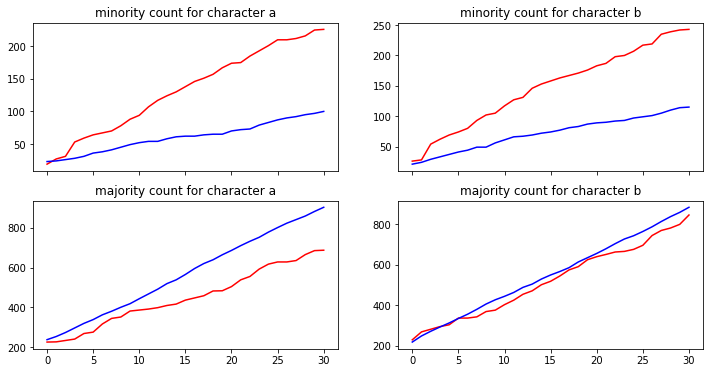

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


x = logs['bald']['epoch']
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, sharex=True,
                                    figsize=(12, 6))
ax0.set_title('minority count for character a')
ax0.plot(x, logs['bald']['train_count_0_red'], color='r')
ax0.plot(x, logs['random']['train_count_0_red'], color='b')

ax1.set_title('minority count for character b')
ax1.plot(x, logs['bald']['train_count_1_blue'], color='r')
ax1.plot(x, logs['random']['train_count_1_blue'], color='b')

ax2.set_title('majority count for character a')
ax2.plot(x, logs['bald']['train_count_0_blue'], color='r')
ax2.plot(x, logs['random']['train_count_0_blue'], color='b')

ax3.set_title('majority count for character b')
ax3.plot(x, logs['bald']['train_count_1_red'], color='r')
ax3.plot(x, logs['random']['train_count_1_red'], color='b')

fig.show()

We demonstrate the `test_loss` and `training_size` using `bald` vs `random` as heuristics. As it is shown, the trainig size increases with the same pace but the above graphs shows the underlying difference in the existing samples for each class which then results in also a better loss decrease using `bald`.

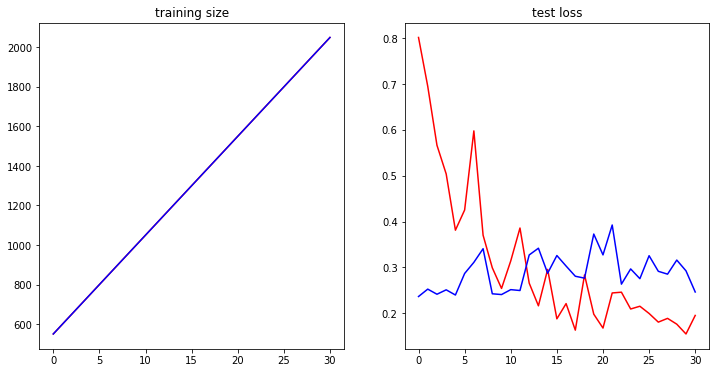

In [9]:
x = logs['bald']['epoch']
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                    figsize=(12, 6))
ax0.set_title('training size')
ax0.plot(x, logs['bald']['active_train_size'], color='r')
ax0.plot(x, logs['random']['active_train_size'], color='b')

ax1.set_title('test loss')
ax1.plot(x, logs['bald']['test_loss'], color='r')
ax1.plot(x, logs['random']['test_loss'], color='b')
fig.show()